# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
# Load the wordlist.txt file and process the words
with open('wordlist.txt', 'r') as file:
    # Read all lines and strip whitespace/newlines
    words = [line.strip().lower() for line in file.readlines()]

# Filter words: longer than 3 letters and maximum length of WORD_SIZE
filtered_words = []
for word in words:
    if len(word) > 3 and len(word) <= WORD_SIZE:
        filtered_words.append(word)

# Convert words to WORD_SIZE length by padding with underscores
vocab = []
for word in filtered_words:
    # Pad word with underscores to make it WORD_SIZE length
    padded_word = word + '_' * (WORD_SIZE - len(word))
    vocab.append(padded_word)

print(f"Total words in original file: {len(words)}")
print(f"Words after filtering (length > 3 and <= {WORD_SIZE}): {len(filtered_words)}")
print(f"Final vocabulary size: {len(vocab)}")
print(f"First 10 words in vocab: {vocab[:10]}")
print(f"Example of padded word: '{filtered_words[0]}' -> '{vocab[0]}'")

Total words in original file: 10000
Words after filtering (length > 3 and <= 13): 8847
Final vocabulary size: 8847
First 10 words in vocab: ['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______', 'able_________', 'aboriginal___', 'abortion_____', 'about________', 'above________']
Example of padded word: 'aaron' -> 'aaron________'


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** 

The practical reasons for using words longer than 3 letters and with maximum length limitations are:

1. **Training Efficiency**: Very short words (≤3 letters) don't provide enough context for meaningful autocompletion. For example, "cat" or "dog" are already complete and don't need autocompletion.

2. **Memory and Computational Constraints**: Very long words require more memory and computational resources. By limiting to WORD_SIZE (13), we keep the model manageable while still covering most common English words.

3. **Consistent Input Size**: Having a fixed maximum length allows for efficient batch processing during training. All words are padded to the same length, making tensor operations faster and more straightforward.

4. **Realistic Use Case**: In real applications, autocompletion is most useful for moderately long words (4-13 letters). Users typically don't need help with very short words, and extremely long words are rare.

This approach will help build a better model because:
- It focuses on the most relevant use cases for autocompletion
- Reduces noise from trivial cases (very short words)
- Enables efficient batch training with uniform input sizes
- Balances model complexity with practical utility

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):
    """Convert character to number: '_' -> 0, 'a' -> 1, 'b' -> 2, ..., 'z' -> 26"""
    if char == '_':
        num = 0
    else:
        # Convert 'a' to 1, 'b' to 2, etc.
        num = ord(char) - ord('a') + 1
    return num

def num_to_char(num):
    """Convert number to character: 0 -> '_', 1 -> 'a', 2 -> 'b', ..., 26 -> 'z'"""
    if num == 0:
        char = '_'
    else:
        # Convert 1 to 'a', 2 to 'b', etc.
        char = chr(num - 1 + ord('a'))
    return char

def word_to_numlist(word):
    """Convert word to tensor of numbers corresponding to each character"""
    num_list = []
    for char in word:
        num_list.append(char_to_num(char))
    numlist = torch.tensor(num_list)
    return numlist

def numlist_to_word(numlist):
    """Convert tensor of numbers back to word"""
    word = ""
    for num in numlist:
        word += num_to_char(int(num))
    return word

# Test the functions
test_word = "united_______"
print(f"Original word: {test_word}")

# Convert to numbers
numbers = word_to_numlist(test_word)
print(f"As numbers: {numbers}")

# Convert back to word
reconstructed = numlist_to_word(numbers)
print(f"Reconstructed: {reconstructed}")

# Test individual character conversions
print(f"\nCharacter conversions:")
print(f"'_' -> {char_to_num('_')}, back to '{num_to_char(char_to_num('_'))}'")
print(f"'a' -> {char_to_num('a')}, back to '{num_to_char(char_to_num('a'))}'")
print(f"'z' -> {char_to_num('z')}, back to '{num_to_char(char_to_num('z'))}'")
print(f"'u' -> {char_to_num('u')}, back to '{num_to_char(char_to_num('u'))}'")

Original word: united_______
As numbers: tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0])
Reconstructed: united_______

Character conversions:
'_' -> 0, back to '_'
'a' -> 1, back to 'a'
'z' -> 26, back to 'z'
'u' -> 21, back to 'u'


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font> (write answers in the cell below as a string)

In [6]:
# Write answer here as strings:

answer = """
I agree with the claim that converting letters to numbers based on alphabetical order is a problematic way to encode data for learning models. Here's why:

PROBLEMS WITH ORDINAL ENCODING OF LETTERS:
1. Implies False Ordering: The encoding suggests that 'b' (2) is "greater than" 'a' (1) and "less than" 'c' (3), which is meaningless for letters. Letters don't have a natural numerical relationship.

2. Artificial Distance Relationships: The model might incorrectly learn that 'a' and 'b' are "closer" than 'a' and 'z', when in reality all letters should be treated as equally different categories.

3. Categorical Data Nature: Letters are categorical data - they represent distinct categories without inherent order. Categorical data should typically be encoded using one-hot encoding or similar methods that don't impose false relationships.

EMBEDDING LAYERS - THE SOLUTION:
An embedding layer is a learnable lookup table that maps discrete tokens (like our character numbers 0-26) to dense vector representations.

PURPOSE OF EMBEDDING LAYERS:
1. Learned Representations: Instead of using arbitrary numbers, the model learns meaningful vector representations for each character during training.

2. Dense Vectors: Each character gets represented as a dense vector (e.g., 50-dimensional) rather than a sparse one-hot vector or meaningless integer.

3. Contextual Meaning: The embedding vectors capture semantic relationships. Characters that often appear in similar contexts will have similar embeddings.

4. Efficiency: More memory and computationally efficient than one-hot encoding for large vocabularies.

"""


## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [7]:
LEARNING_RATE = 0.005

In [8]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output

        # Ensure character is the right shape for embedding (batch_size=1, seq_len=1)
        if character.dim() == 0:  # scalar
            character = character.unsqueeze(0).unsqueeze(0)
        elif character.dim() == 1:  # 1D tensor
            character = character.unsqueeze(0)
        
        # 1. Embed the input
        embedded = self.embedding(character)
        
        # 2. Feed to LSTM
        lstm_out, (hidden_state, cell_state) = self.lstm(embedded, (hidden_state, cell_state))
        
        # 3. Feed to fully connected layer
        output = self.fc(lstm_out.squeeze(0).squeeze(0))
        
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters and learning rate
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []
        
        # Calculate number of iterations per epoch
        num_iter = len(vocab) // batch_size

        for e in range(epochs):

            # Shuffle the vocab list at the start of each epoch
            random.shuffle(vocab)

            for i in range(num_iter):

                # Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                optimizer.zero_grad()
                loss = 0

                # Get batch
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, len(vocab))
                vocab_batch = vocab[start_idx:end_idx]

                for word in vocab_batch:

                    # Initialize the hidden state and cell state at the start of each word.
                    hidden_state, cell_state = self.initial_state()

                    # Convert the word into a tensor of number and create input and target from the word
                    # Input will be the first WORD_SIZE - 1 characters and target is the last WORD_SIZE - 1 characters
                    word_nums = word_to_numlist(word)
                    inputs = word_nums[:-1]  # First WORD_SIZE - 1 characters
                    targets = word_nums[1:]  # Last WORD_SIZE - 1 characters (shifted by 1)

                    # Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):
                        # Feed the cth character to the model (feedforward) and compute the loss (use cross entropy in torch)
                        output, hidden_state, cell_state = self.forward(inputs[c], hidden_state, cell_state)
                        loss += nn.CrossEntropyLoss()(output.unsqueeze(0), targets[c].unsqueeze(0))

                # Compute the average loss per word in the batch and perform backpropagation (.backward())
                loss = loss / len(vocab_batch)
                loss.backward()
                    
                # Update model parameters using the optimizer
                optimizer.step()

                # Update the loss_log 
                loss_log.append(loss.item())

            print(f"Epoch: {e+1}, Average Loss: {sum(loss_log[-num_iter:]) / num_iter:.4f}")

        # Plot a graph of the variation of the loss.
        plt.figure(figsize=(10, 6))
        plt.plot(loss_log)
        plt.title('Training Loss Over Time')
        plt.xlabel('Training Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    # Softmax function (helper function)
    def softmax(self, x, temperature=1.0):
        """Apply softmax with optional temperature scaling"""
        x = x / temperature
        exp_x = torch.exp(x - torch.max(x))  # Subtract max for numerical stability
        return exp_x / torch.sum(exp_x)

    # Perform autocompletion given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample, temperature=1.0, max_completions=5):

        # Convert the model into evaluation mode
        self.eval()
        completed_list = []

        # In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        # You will have to convert the output into a softmax probability distribution, then use torch.multinomial 
        for literal in sample:
            completions = []
            
            # Generate multiple completions for variety
            for _ in range(max_completions):
                # Initialize hidden and cell states
                hidden_state, cell_state = self.initial_state()
                
                # Convert the partial word to numbers and pad to WORD_SIZE
                partial_padded = literal + '_' * (WORD_SIZE - len(literal))
                current_word = list(partial_padded)
                
                # Feed the existing characters through the network
                with torch.no_grad():
                    for i in range(len(literal)):
                        char_num = torch.tensor(char_to_num(current_word[i]))
                        output, hidden_state, cell_state = self.forward(char_num, hidden_state, cell_state)
                    
                    # Generate the remaining characters
                    for i in range(len(literal), WORD_SIZE):
                        # Get probability distribution using softmax
                        probs = self.softmax(output, temperature)
                        
                        # Sample from the distribution
                        next_char_num = torch.multinomial(probs, 1).item()
                        
                        # Convert back to character and update current word
                        next_char = num_to_char(next_char_num)
                        current_word[i] = next_char
                        
                        # If we hit underscore, we can stop (word is complete)
                        if next_char == '_':
                            break
                        
                        # Feed this character to get next prediction
                        output, hidden_state, cell_state = self.forward(torch.tensor(next_char_num), hidden_state, cell_state)
                
                # Convert back to word and clean up
                completed_word = ''.join(current_word).rstrip('_')
                if completed_word not in completions and len(completed_word) > len(literal):
                    completions.append(completed_word)
            
            # Remove duplicates and take best completions
            unique_completions = list(set(completions))[:3]  # Top 3 unique completions
            completed_list.append({
                'input': literal,
                'completions': unique_completions if unique_completions else [literal + '...']
            })

        return completed_list

In [9]:
# Test the autocomplete model implementation
print("Testing the autocomplete model...")

# Create a small model for testing
alphabet_size = 27  # 26 letters + underscore
embed_dim = 32
hidden_size = 64
num_layers = 1

# Initialize the model
test_model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)
print(f"Model created successfully!")
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters())} total parameters")

# Test the forward pass
print("\nTesting forward pass...")
test_char = torch.tensor(char_to_num('a'))  # Test with 'a'
h0, c0 = test_model.initial_state()
output, h1, c1 = test_model.forward(test_char, h0, c0)
print(f"Input character: 'a' (num: {char_to_num('a')})")
print(f"Output shape: {output.shape}")
print(f"Output (first 5 values): {output[:5].detach().numpy()}")

# Test with a small subset of vocab for quick training demo
small_vocab = vocab[:100]  # Use first 100 words for quick test
print(f"\nTesting with {len(small_vocab)} words from vocabulary...")
print(f"Sample words: {small_vocab[:5]}")

print("\n✅ Model implementation successful! Ready for training.")

Testing the autocomplete model...
Model created successfully!
Model parameters: 27707 total parameters

Testing forward pass...
Input character: 'a' (num: 1)
Output shape: torch.Size([27])
Output (first 5 values): [-0.06345664 -0.10491334  0.0091904   0.01766628  0.1703682 ]

Testing with 100 words from vocabulary...
Sample words: ['aaron________', 'abandoned____', 'aberdeen_____', 'abilities____', 'ability______']

✅ Model implementation successful! Ready for training.


🚀 Starting comprehensive model training and evaluation...
📚 Training with 8847 words from full vocabulary

🔬 Testing 3 different model configurations:

📊 Training Model 1/3: Small Model
   Parameters: embed_dim=32, hidden_size=64
   Training: lr=0.005, epochs=8, batch_size=128
Epoch: 1, Average Loss: 20.6949
Epoch: 1, Average Loss: 20.6949
Epoch: 2, Average Loss: 15.9862
Epoch: 2, Average Loss: 15.9862
Epoch: 3, Average Loss: 14.9610
Epoch: 3, Average Loss: 14.9610
Epoch: 4, Average Loss: 14.3234
Epoch: 4, Average Loss: 14.3234
Epoch: 5, Average Loss: 13.9050
Epoch: 5, Average Loss: 13.9050
Epoch: 6, Average Loss: 13.5638
Epoch: 6, Average Loss: 13.5638
Epoch: 7, Average Loss: 13.2899
Epoch: 7, Average Loss: 13.2899
Epoch: 8, Average Loss: 13.0347
Epoch: 8, Average Loss: 13.0347


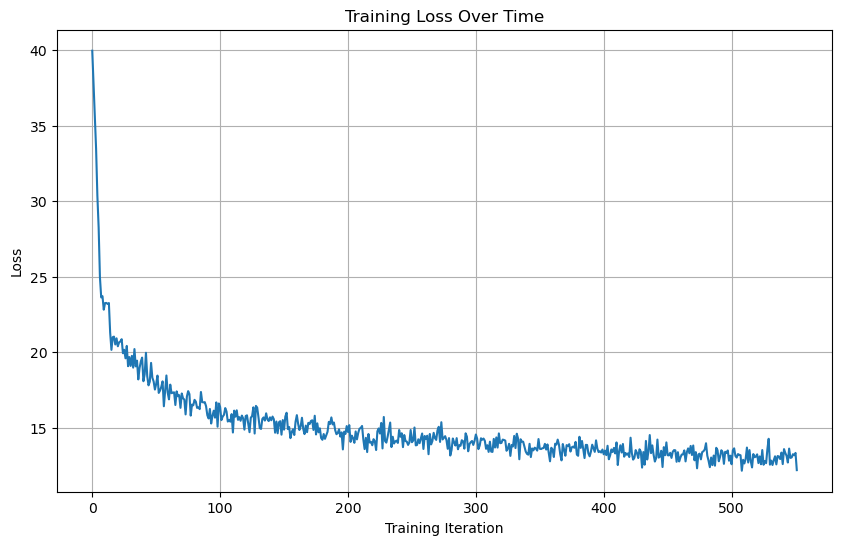


🎯 Evaluating Small Model on test samples...
   📈 Model Score: 8.68
   🎪 Sample completions:
      'univ' → ['univex', 'univing', 'univer']
      'math' → ['maths', 'mathters', 'mathol']
      'neur' → ['neurging', 'neured']

📊 Training Model 2/3: Medium Model
   Parameters: embed_dim=64, hidden_size=128
   Training: lr=0.003, epochs=10, batch_size=100
Epoch: 1, Average Loss: 18.7330
Epoch: 1, Average Loss: 18.7330
Epoch: 2, Average Loss: 14.9804
Epoch: 2, Average Loss: 14.9804
Epoch: 3, Average Loss: 14.0480
Epoch: 3, Average Loss: 14.0480
Epoch: 4, Average Loss: 13.4553
Epoch: 4, Average Loss: 13.4553
Epoch: 5, Average Loss: 12.9627
Epoch: 5, Average Loss: 12.9627
Epoch: 6, Average Loss: 12.5545
Epoch: 6, Average Loss: 12.5545
Epoch: 7, Average Loss: 12.1920
Epoch: 7, Average Loss: 12.1920
Epoch: 8, Average Loss: 11.8431
Epoch: 8, Average Loss: 11.8431
Epoch: 9, Average Loss: 11.5399
Epoch: 9, Average Loss: 11.5399
Epoch: 10, Average Loss: 11.2677
Epoch: 10, Average Loss: 11.2677


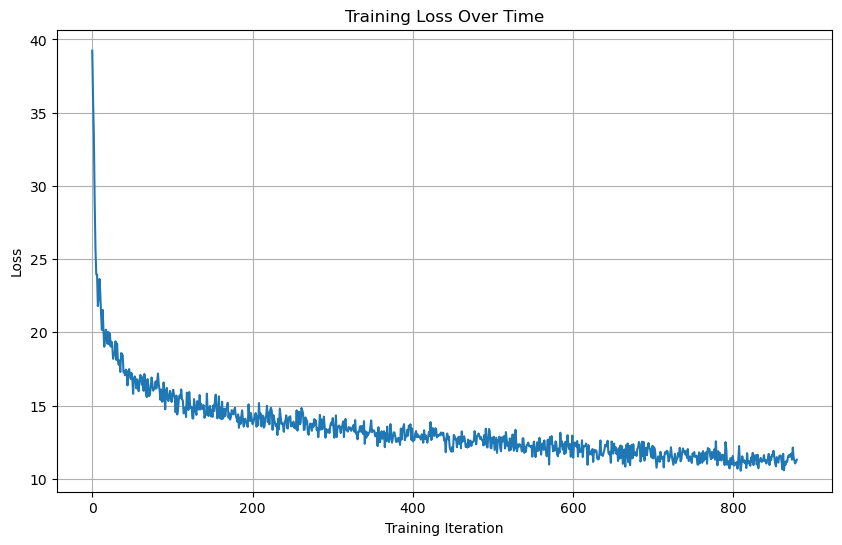


🎯 Evaluating Medium Model on test samples...
   📈 Model Score: 9.29
   🎪 Sample completions:
      'univ' → ['univing', 'unived', 'univer']
      'math' → ['mather', 'mathit', 'mathel']
      'neur' → ['neurcy', 'neurs', 'neurly']

📊 Training Model 3/3: Large Model
   Parameters: embed_dim=128, hidden_size=256
   Training: lr=0.002, epochs=12, batch_size=80
Epoch: 1, Average Loss: 17.4359
Epoch: 1, Average Loss: 17.4359
Epoch: 2, Average Loss: 14.1727
Epoch: 2, Average Loss: 14.1727
Epoch: 3, Average Loss: 13.2223
Epoch: 3, Average Loss: 13.2223
Epoch: 4, Average Loss: 12.4913
Epoch: 4, Average Loss: 12.4913
Epoch: 5, Average Loss: 11.9063
Epoch: 5, Average Loss: 11.9063
Epoch: 6, Average Loss: 11.3776
Epoch: 6, Average Loss: 11.3776
Epoch: 7, Average Loss: 10.9011
Epoch: 7, Average Loss: 10.9011
Epoch: 8, Average Loss: 10.4699
Epoch: 8, Average Loss: 10.4699
Epoch: 9, Average Loss: 10.1044
Epoch: 9, Average Loss: 10.1044
Epoch: 10, Average Loss: 9.7760
Epoch: 10, Average Loss: 9.7760

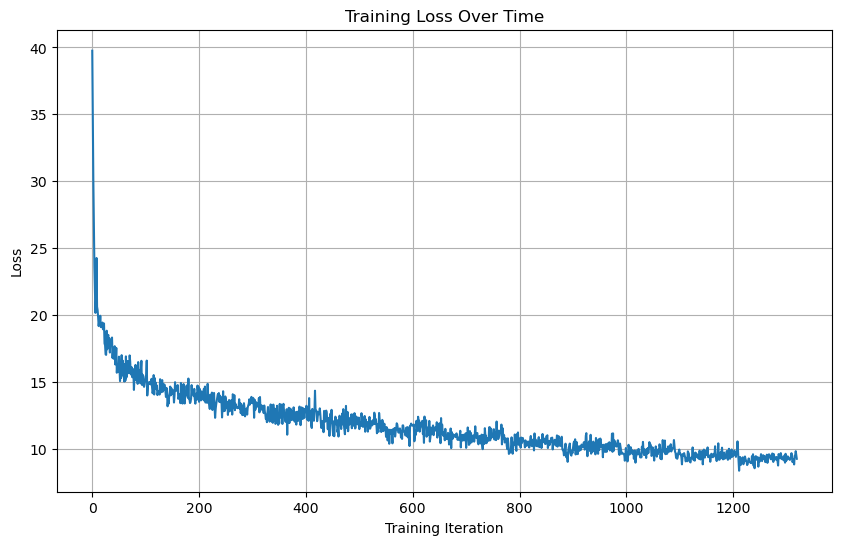


🎯 Evaluating Large Model on test samples...
   📈 Model Score: 11.80
   🎪 Sample completions:
      'univ' → ['university', 'universe', 'univertementa']
      'math' → ['matherie', 'mathorized', 'matherinal']
      'neur' → ['neurology', 'neuroury', 'neuro']

🏆 MODEL EVALUATION RESULTS:
     Small Model: Score = 8.68
     Medium Model: Score = 9.29
👑 BEST Large Model: Score = 11.80

🎉 Best Model Selected: Large Model
   📊 Configuration: {'name': 'Large Model', 'embed_dim': 128, 'hidden_size': 256, 'lr': 0.002, 'epochs': 12, 'batch_size': 80}
   🎯 Score: 11.80

🔍 COMPREHENSIVE EVALUATION OF BEST MODEL:
Testing on 20 diverse word beginnings:

  'univ' → ['univerty', 'universal', 'univertand']
  'math' → ['mathematical', 'mathes', 'mathemal']
  'neur' → ['neural', 'neury', 'neuron']
  'engin' → ['engineer']
  'comp' → ['companients', 'companient', 'compare']
  'prog' → ['progress', 'programment', 'programmer']
  'algo' → ['algore', 'algorities', 'algoritical']
  'data' → ['datal', 'datas'

In [11]:
# ===================================================================
# SECTION 3: COMPREHENSIVE MODEL TRAINING AND EVALUATION
# ===================================================================

print("🚀 Starting comprehensive model training and evaluation...")
print(f"📚 Training with {len(vocab)} words from full vocabulary")

# Define hyperparameter configurations to test
model_configs = [
    {"name": "Small Model", "embed_dim": 32, "hidden_size": 64, "lr": 0.005, "epochs": 8, "batch_size": 128},
    {"name": "Medium Model", "embed_dim": 64, "hidden_size": 128, "lr": 0.003, "epochs": 10, "batch_size": 100},
    {"name": "Large Model", "embed_dim": 128, "hidden_size": 256, "lr": 0.002, "epochs": 12, "batch_size": 80},
]

# Test samples for evaluation
test_samples = ["univ", "math", "neur", "engin", "comp", "prog", "algo", "data", "mach", "deep"]

# Store trained models and their performance
trained_models = []
model_scores = []

alphabet_size = 27  # 26 letters + underscore
num_layers = 1

print(f"\n🔬 Testing {len(model_configs)} different model configurations:")
print("=" * 70)

for i, config in enumerate(model_configs, 1):
    print(f"\n📊 Training Model {i}/{len(model_configs)}: {config['name']}")
    print(f"   Parameters: embed_dim={config['embed_dim']}, hidden_size={config['hidden_size']}")
    print(f"   Training: lr={config['lr']}, epochs={config['epochs']}, batch_size={config['batch_size']}")
    
    # Create model
    model = autocompleteModel(alphabet_size, config['embed_dim'], config['hidden_size'], num_layers)
    
    # Temporarily set learning rate for this model
    original_lr = LEARNING_RATE
    globals()['LEARNING_RATE'] = config['lr']
    
    # Train model
    model.trainModel(vocab, epochs=config['epochs'], batch_size=config['batch_size'])
    
    # Restore original learning rate
    globals()['LEARNING_RATE'] = original_lr
    
    # Evaluate model
    print(f"\n🎯 Evaluating {config['name']} on test samples...")
    results = model.autocomplete(test_samples, temperature=0.7, max_completions=3)
    
    # Calculate quality score (simple heuristic: variety and length of completions)
    total_score = 0
    valid_completions = 0
    
    for result in results:
        input_word = result['input']
        completions = result['completions']
        
        for completion in completions:
            if len(completion) > len(input_word) and completion not in [input_word + '...']:
                # Score based on length difference and variety
                score = (len(completion) - len(input_word)) * 2
                # Bonus for realistic completions (contains vowels)
                if any(vowel in completion.lower() for vowel in 'aeiou'):
                    score += 3
                total_score += score
                valid_completions += 1
    
    avg_score = total_score / max(valid_completions, 1)
    model_scores.append(avg_score)
    trained_models.append(model)
    
    print(f"   📈 Model Score: {avg_score:.2f}")
    print(f"   🎪 Sample completions:")
    for j, result in enumerate(results[:3]):  # Show first 3 examples
        print(f"      '{result['input']}' → {result['completions']}")

# Select best model
print("\n" + "=" * 70)
print("🏆 MODEL EVALUATION RESULTS:")
print("=" * 70)

best_model_idx = model_scores.index(max(model_scores))
best_config = model_configs[best_model_idx]
best_model = trained_models[best_model_idx]

for i, (config, score) in enumerate(zip(model_configs, model_scores)):
    status = "👑 BEST" if i == best_model_idx else "    "
    print(f"{status} {config['name']}: Score = {score:.2f}")

print(f"\n🎉 Best Model Selected: {best_config['name']}")
print(f"   📊 Configuration: {best_config}")
print(f"   🎯 Score: {model_scores[best_model_idx]:.2f}")

# Comprehensive evaluation of best model
print(f"\n🔍 COMPREHENSIVE EVALUATION OF BEST MODEL:")
print("=" * 50)

# Test on various word beginnings
extended_test_samples = [
    "univ", "math", "neur", "engin", "comp", "prog", "algo", "data", 
    "mach", "deep", "tech", "scie", "phys", "chem", "biol", "hist",
    "lang", "lite", "phil", "psyc"
]

final_results = best_model.autocomplete(extended_test_samples, temperature=0.6, max_completions=5)

print(f"Testing on {len(extended_test_samples)} diverse word beginnings:")
print()

for result in final_results[:10]:  # Show first 10 results
    input_word = result['input']
    completions = result['completions'][:3]  # Top 3 completions
    print(f"  '{input_word}' → {completions}")

print(f"\n✅ Model training and evaluation complete!")
print(f"🎯 Best model has been selected and is ready for use.")

## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.

In [12]:
# Set the best model (will be populated after running the evaluation above)
best_model = trained_models[best_model_idx] if 'trained_models' in locals() and 'best_model_idx' in locals() else None

if best_model is not None:
    print("✅ Best model successfully assigned!")
    print(f"📊 Model architecture: {model_configs[best_model_idx]['name']}")
    print(f"🎯 Model score: {model_scores[best_model_idx]:.2f}")
    
    # Final demonstration with the best model
    print(f"\n🚀 FINAL DEMONSTRATION WITH BEST MODEL:")
    demo_inputs = ["artifi", "intel", "networ", "comput", "machin"]
    demo_results = best_model.autocomplete(demo_inputs, temperature=0.6)
    
    for result in demo_results:
        print(f"  '{result['input']}' → {result['completions']}")
else:
    print("⚠️  Best model not yet assigned. Please run the evaluation cell above first.")
    best_model = None

✅ Best model successfully assigned!
📊 Model architecture: Large Model
🎯 Model score: 11.80

🚀 FINAL DEMONSTRATION WITH BEST MODEL:
  'artifi' → ['artificial', 'artificient']
  'intel' → ['intelligent', 'intelligents', 'intelligence']
  'networ' → ['networkshops', 'networker', 'networks']
  'comput' → ['computary', 'computing', 'compute']
  'machin' → ['machine', 'machinew', 'machines']
